# GP Emulation of 6S

In [20]:
%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from __future__ import annotations
import gpytorch
import numpy as np
import torch
from typing import Final
import xarray as xr
import matplotlib.pyplot as plt
from tkinter import filedialog

import rtm_wrapper_gp as rtm_gp
import alive_progress
import rtm_wrapper.parameters as rtm_param
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation
import scipy.stats.qmc as sci_qmc

Use GPU if available:

In [2]:
print(torch.cuda.device_count())
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

1


# Run a sweep simulation

## Define input ranges

In [3]:
WATER_RANGE: Final = (1, 4)  # g/cm^2
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm

WAVELENGTHS: Final = np.arange(0.5, 0.65, 0.0025)  # micrometers

## Sample inputs

In [4]:
NUM_SAMPLES: Final = 120

rng = np.random.default_rng(2023_08_14)
lhs_sampler = sci_qmc.LatinHypercube(d=2, seed=rng)

raw_samples = lhs_sampler.random(NUM_SAMPLES)

water_samples = rtm_gp.unit2range(raw_samples[:, 0], *WATER_RANGE)
ozone_samples = rtm_gp.unit2range(raw_samples[:, 1], *OZONE_RANGE)

## Plot atmosphere samples

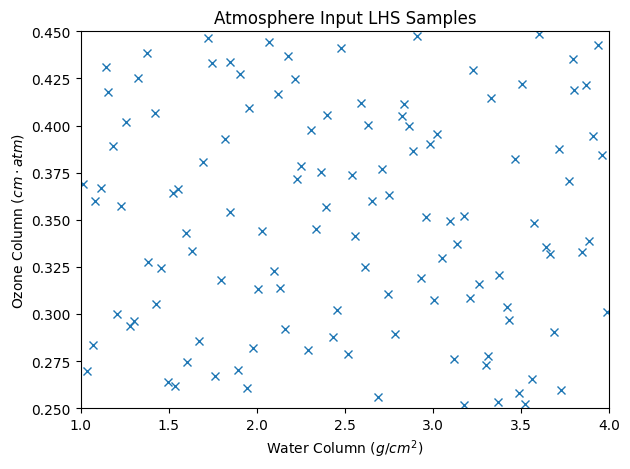

In [5]:
fig, ax = plt.subplots()
ax.plot(water_samples, ozone_samples, "x"),
ax.set_xlabel("Water Column ($g/cm^2$)")
ax.set_ylabel("Ozone Column ($cm\cdot atm$)")
ax.set_xlim(WATER_RANGE)
ax.set_ylim(OZONE_RANGE)
ax.set_title("Atmosphere Input LHS Samples")
fig.tight_layout()

## Perform simulation

In [6]:
sweep = SweepSimulation(
    {
        "lhs": {
            "atmosphere__water": water_samples,
            "atmosphere__ozone": ozone_samples,
        },
        "wavelength__value": WAVELENGTHS,
    },
    base=pysixs_default_inputs().replace(
        atmosphere=rtm_param.AtmosphereWaterOzone(2, 0.3)
    ),
)
engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)

with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())
results = runner.collect_results()
display(results)

|████████████████████████████████████████| 7320/7320 [100%] in 23.0s (318.24/s) 


<xarray.Dataset>
Dimensions:                        (lhs: 120, wavelength__value: 61)
Coordinates:
  * lhs                            (lhs) int64 0 1 2 3 4 ... 115 116 117 118 119
    atmosphere__ozone              (lhs) float64 0.3481 0.2999 ... 0.3039 0.2594
    atmosphere__water              (lhs) float64 3.576 1.209 3.21 ... 3.42 3.727
  * wavelength__value              (wavelength__value) float64 0.5 ... 0.65
Data variables:
    transmittance_direct_down      (lhs, wavelength__value) float64 0.4594 .....
    apparent_radiance              (lhs, wavelength__value) float64 134.5 ......
    transmittance_scattering_up    (lhs, wavelength__value) float64 1.0 ... 1.0
    transmittance_direct_up        (lhs, wavelength__value) float64 0.4884 .....
    transmittance_diffuse_down     (lhs, wavelength__value) float64 0.4021 .....
    transmittance_diffuse_up       (lhs, wavelength__value) float64 0.5116 .....
    transmittance_scattering_down  (lhs, wavelength__value) float64 0.8614 .....
Attributes:
    version:     0.2.0.dev0
    platform:    CPython 3.10.12 (Linux paridae 6.2.0-26-generic #26~22.04.1-...
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(altitude_sensor=AltitudePredefined(name='sealevel'), ...
    base_pzb64:  H4sIAGuD32QC/2VRzUoDMRBW6ZZihYKI+AgK0osPIL1YRcUiSI9ltju7CSSZ...
    sim_start:   2023-08-18T10:42:28.305528-04:00
    sim_end:     2023-08-18T10:42:51.301765-04:00

## Marshal input data into torch tensors

In [7]:
input_dims, train_x, train_y = rtm_gp.dataarray2tensors(results.apparent_radiance)
train_x = train_x.float().to(device)
train_y = train_y.float().to(device)

print(f"{input_dims=} {train_x.shape=}, {train_y.shape=}")

input_dims=('atmosphere__ozone', 'atmosphere__water', 'wavelength__value') train_x.shape=torch.Size([7320, 3]), train_y.shape=torch.Size([7320])


# Create emulator

## Design basic GP model

In [73]:
from gpytorch import constraints


class Model(gpytorch.models.ExactGP):
    def __init__(
        self, train_x: torch.Tensor, train_y: torch.Tensor, likelihood: torch.Module
    ) -> None:
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.shape[-1])
        # self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = (
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
            + gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
            + gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.full((train_x.shape[-1],), 1e-3), learn_additional_noise=False)
model = Model(train_x, train_y, likelihood).to(device)

## Train GP model

In [74]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 300
bar = alive_progress.alive_it(range(training_iter), force_tty=True)
for _ in bar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    print(f"loss: {loss.item():0.3f}")
    optimizer.step()

on 0: loss: 7.979                                                               
on 1: loss: 7.354                                                               
on 2: loss: 6.820                                                               
on 3: loss: 6.350                                                               
on 4: loss: 5.949                                                               
on 5: loss: 5.603                                                               
on 6: loss: 5.302                                                               
on 7: loss: 5.041                                                               
on 8: loss: 4.812                                                               
on 9: loss: 4.611                                                               
on 10: loss: 4.434                                                              
on 11: loss: 4.276                                                              
on 12: loss: 4.136          

# Asses emulator


## Generate test data

In [26]:
water_test = np.linspace(*WATER_RANGE, 4)
ozone_test = np.linspace(*OZONE_RANGE, 6)

## Obtain actual sim results for test data

In [27]:
reuse_test = ""  # "test_results_1806.nc"

if reuse_test:
    test_results = xr.load_dataset(reuse_test)
else:
    sweep = SweepSimulation(
        {
            "atmosphere__water": water_test,
            "atmosphere__ozone": ozone_test,
            "wavelength__value": WAVELENGTHS,
        },
        base=pysixs_default_inputs().replace(
            atmosphere=rtm_param.AtmosphereWaterOzone(1, 0.5)
        ),
    )
    engine = PySixSEngine()
    runner = ConcurrentExecutor(max_workers=16)

    with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
        runner.run(sweep, engine, step_callback=lambda _: bar())
    test_results = runner.collect_results()

display(test_results)

|████████████████████████████████████████| 1464/1464 [100%] in 4.7s (310.01/s)  


<xarray.Dataset>
Dimensions:                        (atmosphere__water: 4, atmosphere__ozone: 6,
                                    wavelength__value: 61)
Coordinates:
  * atmosphere__water              (atmosphere__water) float64 1.0 2.0 3.0 4.0
  * atmosphere__ozone              (atmosphere__ozone) float64 0.25 ... 0.45
  * wavelength__value              (wavelength__value) float64 0.5 ... 0.65
Data variables:
    transmittance_direct_down      (atmosphere__water, atmosphere__ozone, wavelength__value) float64 ...
    apparent_radiance              (atmosphere__water, atmosphere__ozone, wavelength__value) float64 ...
    transmittance_scattering_up    (atmosphere__water, atmosphere__ozone, wavelength__value) float64 ...
    transmittance_direct_up        (atmosphere__water, atmosphere__ozone, wavelength__value) float64 ...
    transmittance_diffuse_down     (atmosphere__water, atmosphere__ozone, wavelength__value) float64 ...
    transmittance_diffuse_up       (atmosphere__water, atmosphere__ozone, wavelength__value) float64 ...
    transmittance_scattering_down  (atmosphere__water, atmosphere__ozone, wavelength__value) float64 ...
Attributes:
    version:     0.2.0.dev0
    platform:    CPython 3.10.12 (Linux paridae 6.2.0-26-generic #26~22.04.1-...
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(altitude_sensor=AltitudePredefined(name='sealevel'), ...
    base_pzb64:  H4sIAPCG32QC/2VQwUoDQQy10JZihYKI+AkK0osfIL1YRcUiSI8l283uDMxM...
    sim_start:   2023-08-18T10:57:47.476928-04:00
    sim_end:     2023-08-18T10:57:52.181097-04:00

In [28]:
# test_results.to_netcdf("test_results_1806.nc")

## Marshal test data into torch tensors

In [75]:
test_input_dims, test_x, test_y = rtm_gp.dataarray2tensors(
    test_results.apparent_radiance
)
test_x = test_x.float().to(device)
test_y = test_y.float().to(device)

assert test_input_dims == input_dims
model.eval()
likelihood.eval()

print(f"{test_input_dims=} {test_x.shape=} {test_y.shape=}")

test_input_dims=('atmosphere__ozone', 'atmosphere__water', 'wavelength__value') test_x.shape=torch.Size([1464, 3]) test_y.shape=torch.Size([1464])


## Evaluate model for test data

In [76]:
with torch.no_grad():
    f_preds = model(test_x)

In [77]:
rmse = torch.sqrt(torch.mean((f_preds.mean - test_y) ** 2))
print(f"RMSE: {rmse:0.2f}")
print(f"Max abs. diff.: {torch.max(f_preds.mean - test_y):0.2f}")

RMSE: 1.84
Max abs. diff.: 10.05


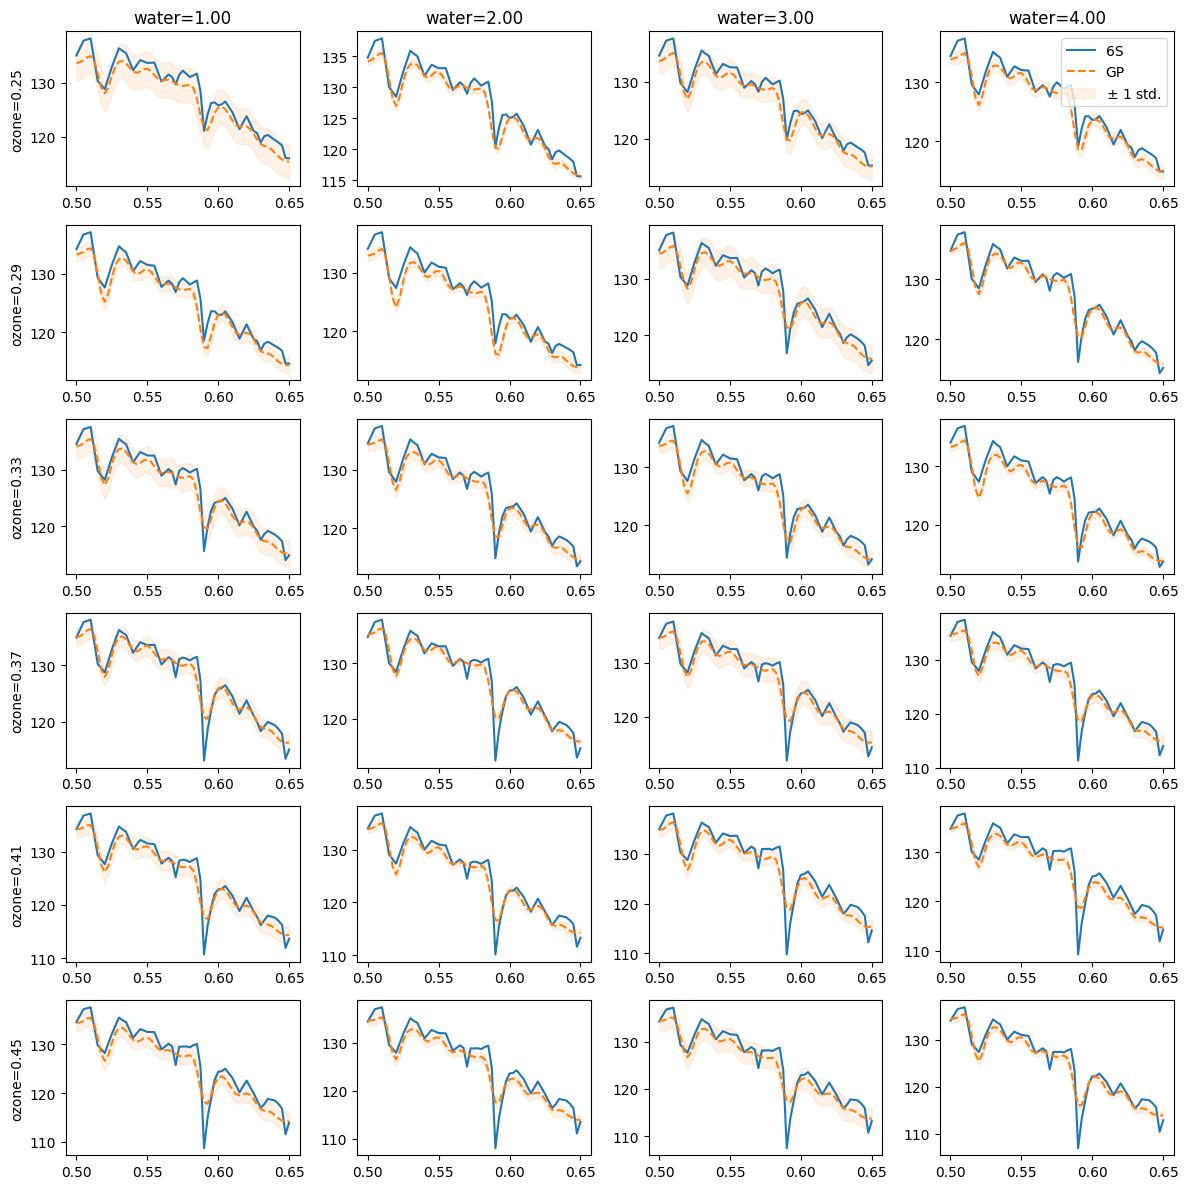

In [78]:
fig_shape = (len(ozone_test), len(water_test))
expected = test_y.cpu().numpy().reshape(*fig_shape, len(WAVELENGTHS))
actual = f_preds.mean.cpu().numpy().reshape(*fig_shape, len(WAVELENGTHS))
actual_var = f_preds.variance.cpu().numpy().reshape(*fig_shape, len(WAVELENGTHS))

fig, axs = plt.subplots(*fig_shape, figsize=(12, 12))

for i_ozone, ax_row in enumerate(axs):
    for i_water, ax in enumerate(ax_row.flat):
        ax.plot(
            WAVELENGTHS,
            expected[i_ozone, i_water, :],
            "-",
            label="6S",
            color="tab:blue",
        )
        ax.plot(
            WAVELENGTHS,
            actual[i_ozone, i_water, :],
            "--",
            label="GP",
            color="tab:orange",
        )
        curr_var = actual_var[i_ozone, i_water, :]
        ax.fill_between(
            WAVELENGTHS,
            actual[i_ozone, i_water, :] - curr_var,
            actual[i_ozone, i_water, :] + curr_var,
            label="$\pm$ 1 std.",
            color="tab:orange",
            alpha=0.1,
        )
        if i_water == 0:
            ax.set_ylabel(f"ozone={ozone_test[i_ozone]:0.2f}")
        if i_ozone == 0:
            ax.set_title(f"water={water_test[i_water]:0.2f}")

axs[0, -1].legend(loc="upper right")
fig.tight_layout()

tensor([6.7286, 6.7595, 6.7919,  ..., 6.7476, 6.7870, 6.8127], device='cuda:0')